In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn import preprocessing
from xgboost import XGBClassifier, XGBRegressor
import datetime

from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


In [2]:
start = datetime.datetime(2017, 8, 1)
end = datetime.datetime(2020, 8, 17)
Indicators = DataReader(["CBBTCUSD", "CBBCHUSD", "CBCCIND", "CBETHUSD", "sp500", "VIXCLS", "T10YIE", "DGS5", "GOLDPMGBD230NLBM", "SLVPRUSD"], 'fred', start, end)\
    .fillna(method="pad").fillna(method="backfill")

In [4]:
Indicators.to_csv('dataset/Indicators.csv', index=True, header=True)

In [3]:
Indicators = pd.read_csv('dataset/Indicators.csv', index_col="DATE")

In [3]:
Indicators

,CBBTCUSD,CBBCHUSD,CBCCIND,CBETHUSD,sp500,VIXCLS,T10YIE,DGS5,GOLDPMGBD230NLBM,SLVPRUSD
DATE,,,,,,,,,,
2017-08-01,2732.59,3746.84,1346.434772,225.73,2476.35,10.09,1.79,1.80,1075.22,16.580
2017-08-02,2699.90,3746.84,1320.244944,217.92,2477.57,10.28,1.79,1.82,1072.56,16.580
2017-08-03,2787.02,3746.84,1360.591607,224.00,2472.16,10.44,1.78,1.79,1069.90,16.580
2017-08-04,2857.34,3746.84,1378.173407,220.72,2476.83,10.03,1.80,1.82,1067.41,16.580
2017-08-05,3243.49,3746.84,1563.954493,251.85,2476.83,10.03,1.80,1.82,1067.41,16.580
...,...,...,...,...,...,...,...,...,...,...
2020-08-12,11563.16,284.25,3180.272971,386.66,3380.35,22.28,1.67,0.30,1640.57,25.810
2020-08-13,11824.99,297.06,3180.272971,426.65,3373.43,22.13,1.67,0.32,1640.17,26.250
2020-08-14,11785.29,294.26,3180.272971,439.26,3372.85,22.05,1.65,0.32,1643.31,26.705


In [4]:
Indicators_pct = Indicators.pct_change()

scaler = preprocessing.MinMaxScaler().fit(Indicators)
Indicators_sca = Indicators.copy()
Indicators_sca[:] = scaler.transform(Indicators)

Indicators_full = pd.concat([Indicators_pct, Indicators_sca], axis=1)

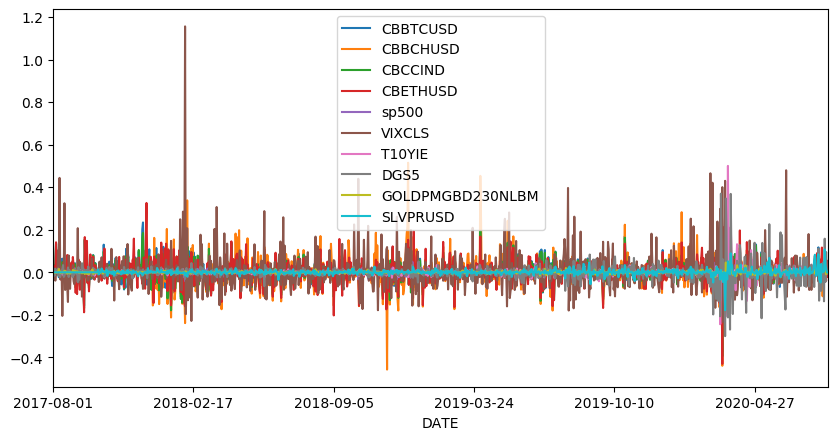

In [5]:
df = pd.DataFrame(Indicators_pct, index=Indicators_pct.index, columns=Indicators_pct.columns.values)
fig = plt.figure(dpi=100)
df.plot(figsize=(10,5), ax = plt.gca())

In [6]:
def getDataMatrix(D, n=5):
    Y = D[n:, 0].copy()
    X = np.zeros((D.shape[0]-n+1, n, D.shape[1]))
    for i in range(n):
        X[:, i, :] = D[i:i+D.shape[0]-n+1, :]
    return X[:-1], Y, np.expand_dims(X[-1], axis=0)

def getDataArray(D, n=5):
    Y = D[n:, 0].copy()
    X = np.zeros((D.shape[0]-n+1, n * D.shape[1]))
    for i in range(n):
        X[:, i*D.shape[1]:(i+1)*D.shape[1]] = D[i:i+D.shape[0]-n+1, :]
    return X[:-1], Y, np.expand_dims(X[-1], axis=0)

In [7]:
n = 10
# X, Y, X_last = getDataMatrix(Indicators_full.values[1:], n)
X, Y, X_last = getDataArray(Indicators_full.values[1:], n)

In [27]:
Y[Y>=0] = 1
Y[Y<0] = -1

In [8]:
print(X.shape, Y.shape, X_last.shape)

(1095, 200) (1095,) (1, 200)


In [9]:
train_set, test_set = train_test_split(range(len(X)), test_size=0.2, shuffle=True)

## Neural Network

In [14]:
x0 = Input((X.shape[1], X.shape[2]))
x = LSTM(100, return_sequences=True)(x0)
x = Flatten()(x)
x = Dense(10)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="tanh")(x)

In [15]:
model = Model(x0, x)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 20)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 100)           48400     
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10010     
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 58,421
Trainable params: 58,421
Non-trainable params: 0
_________________________________________________________

In [16]:
model.fit(X[train_set], Y[train_set], batch_size=8, epochs=20, validation_data=(X[test_set], Y[test_set]))

Epoch 1/20
110/110 [==============================] - 1s 7ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 2/20
110/110 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 3/20
110/110 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 4/20
110/110 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 5/20
110/110 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 6/20
110/110 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 7/20
110/110 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/20
110/110 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/20
110/110 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 10/20
110/110 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 0.0022

In [17]:
y_pred = model.predict(X_last)

In [18]:
y_pred

array([[0.01100253]], dtype=float32)

In [19]:
Indicators["CBBTCUSD"][-1] * (1+y_pred[0][0])

12027.078158213404

## XGBoost

In [10]:
ALGORITHMS = {
    'XGB': {
        'model': XGBClassifier(n_jobs=4),
        'params': {
            "n_estimators": [30, 50, 100],
            "max_depth": [6, 7, 8],
            "eta": [0.01, 0.001],
        }
    },
    'SVM': {
        'model': SVR(gamma='scale'),
        'params': {
            "kernel": ['linear', 'rbf' ], # 'poly', 'sigmoid'
            "C": [0.1, 1.0, 100.0, 10000.0],
            "epsilon": [0.001, 1.0],
        }
    }
}

method = "SVM"
CV = 3

model = GridSearchCV(
    ALGORITHMS[method]['model'],
    ALGORITHMS[method]['params'],
    cv=CV,
    n_jobs=-1,
)

In [12]:
model.fit(X[train_set], Y[train_set])
print("MSE:", mean_squared_error(y_pred, Y[test_set]))
print("Trainning MSE:", mean_squared_error(model.predict(X[train_set]), Y[train_set]))

NameError: name 'mean_squared_error' is not defined

In [18]:
model.predict(X_last)

array([-1.])

In [19]:
model.predict(np.expand_dims(X[-3], 0))

array([1.])